# Проверочная работа. Предсказание анализа биоптата молочных желез

Описание задания: 
1. Загрузить файл data_breast.csv. В данном файле собрана расчетная информация с обработанных изображений биоптата молочных желез женщин. Задача заключается в предсказании переменной “Diagnosis” - является ли содержимое биоптата доброкачественным (значение “B” – benign) либо злокачественным (значение “M” – malicious). Описание данных доступно на сайте https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29
2. Рассчитать основные статистики для переменных (среднее, медиана, мода, мин/макс, сред. отклонение).
3. Выбрать стратегию для работы с пропущенными значениями.
4. Рассчитать и визуализировать корреляционную матрицу для переменных.
5. Визуализировать взаимосвязи между переменными.
6. С помощью статистических методов проверить взаимосвязи между переменными.
7. Выбрать стратегию Feature Selection – сокращение размерности либо генерация новых переменных. Какой из этих
двух подходов даст лучший результат при классификации?
8. Провести стратегию Oversampling/Undersampling, проверить дает ли она улучшение результатов.
9. Сделать кросс-валидацию данных с использованием подхода K-fold (n_folds=10).
10. Рассчитать Feature Selection для выбранных переменных.
11. Решить задачу бинарной классификации и предсказать переменную ”Diagnosis ” протестировав как минимум 2
алгоритма. Использовать те алгоритмы, которые позволяют предсказать вероятность класса (proba). Рассчитать и
вывести вероятность каждого класса.
12. Проверить качество классификации с использованием следующих метрик: Accuracy, F1-Score, Precision, Recall
13. Проверить качество вероятности класса с использованием метрики: Brier Score
14. * Осуществить запуск вашего скрипта с использованием Docker.
15. Загрузить результат (в формате .ipynb ноутбука либо докер реализации) в репозиторий. Разместить ссылку в лк

## 0. Импорт библиотек

In [119]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt

# Модель
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Метод кросс-валидации
from sklearn.grid_search import RandomizedSearchCV

## 1. Загрузка данных

In [83]:
data = pd.read_csv('data_breast.csv')
data = data.drop('Unnamed: 32', axis=1)
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## 2. Расчет основных статистик 
#### (среднее, медиана, мода, мин/макс, сред. отклонение)

In [84]:
# Расчитываем основные статистики для средних значений измерений
def describe(df, stats):
    d = df.describe()
    return d.append(df.agg(stats))

describe(data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']], ['median'])


,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440
median,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540


## 3. Заполнение пропущенных значений
##### Пропущенных значений нет

## 4. Корреляция переменных

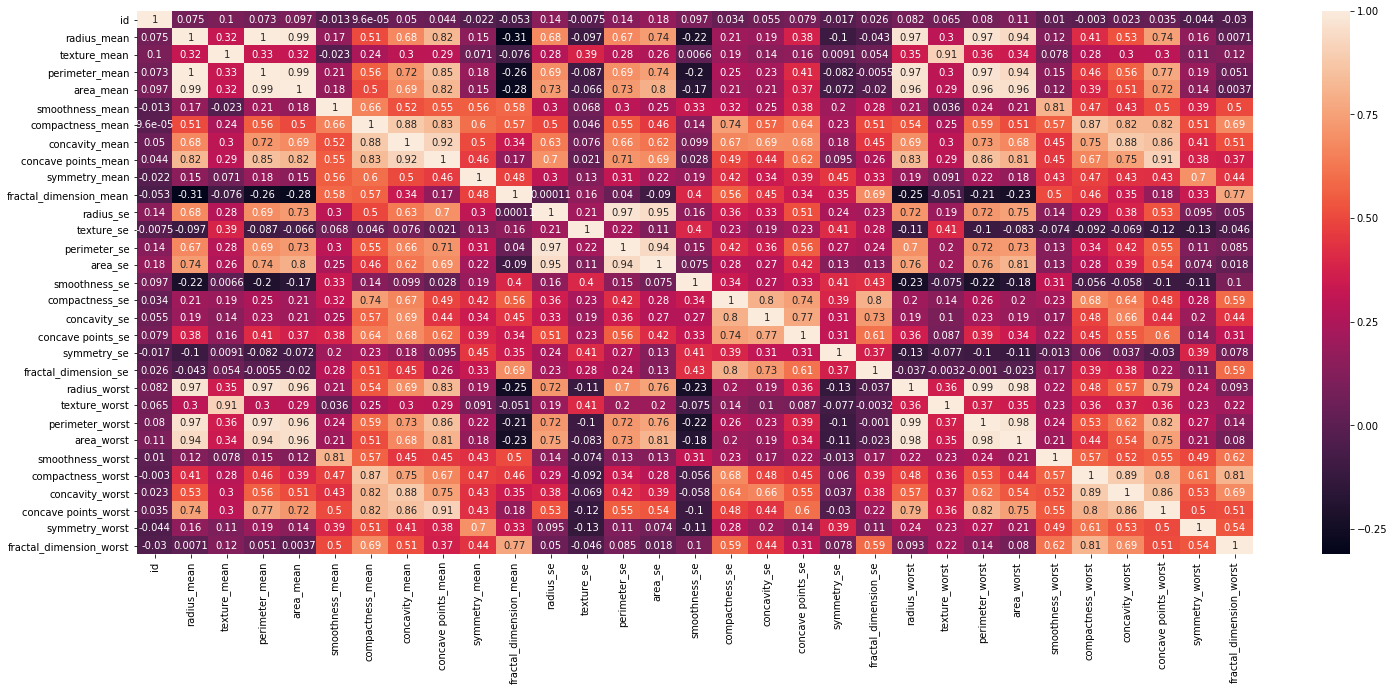

In [85]:
# Общая матрица корреляции
plt.figure(figsize=(25,10))
sns.heatmap(data.corr(), annot=True)

/Users/akirichenko/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


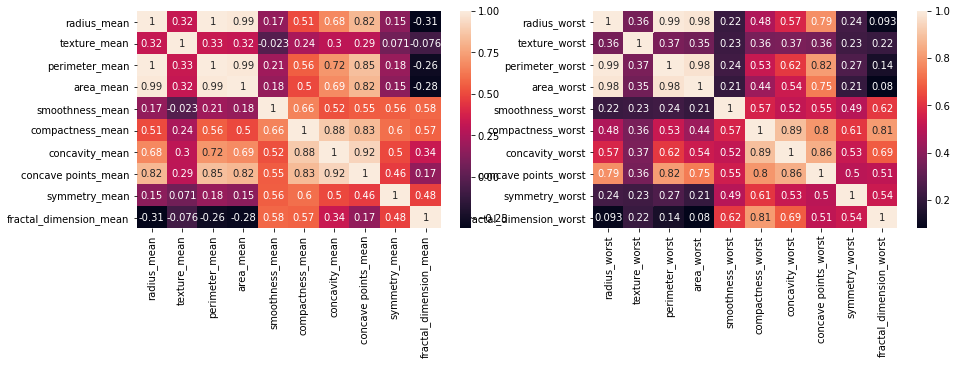

In [86]:
fig, ax = plt.subplots(1,2, figsize=(15,4))

# Корреляция средних значений
sns.heatmap(data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']].corr(), annot=True, ax=ax[0])

# Корреляция максимальных значений 
sns.heatmap(data[['radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].corr(), annot=True, ax=ax[1])

fig.show()

## 5. Взаимосвязь между переменными
#### Анализируем зависимости между средними значениями переменных

In [87]:
means = data[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean']]

worst = data[['radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']]

std = data[['radius_se', 'texture_se',
       'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se',
       'symmetry_se', 'fractal_dimension_se']]

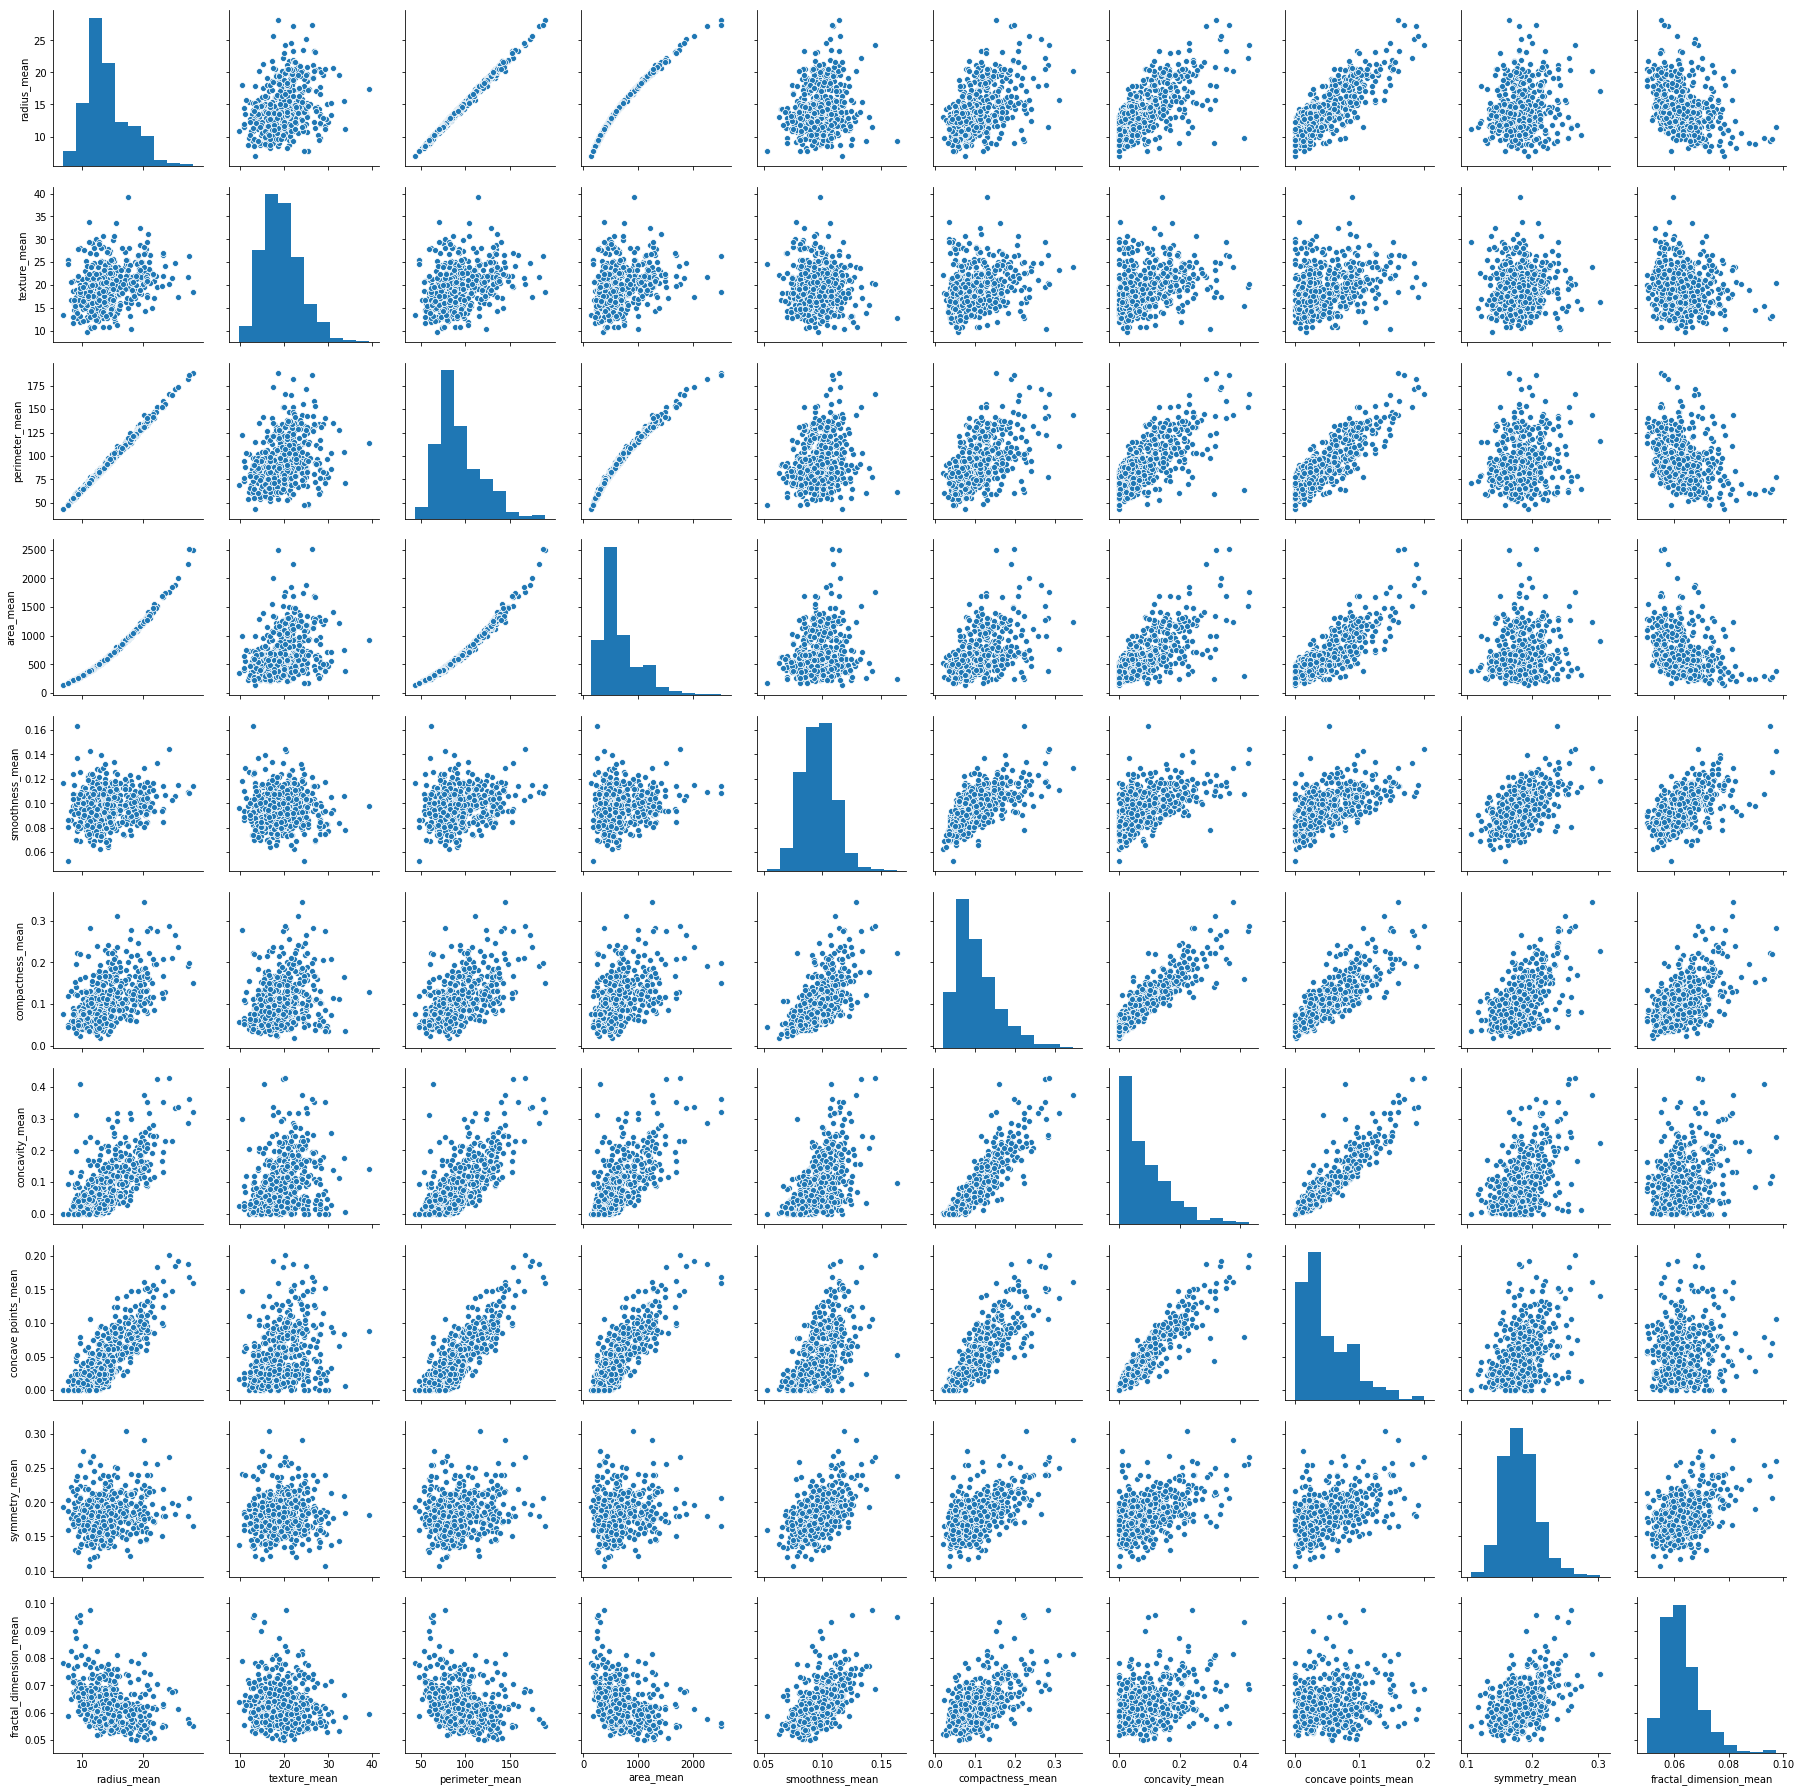

In [88]:
# Зависимость признаков
sns.pairplot(means)

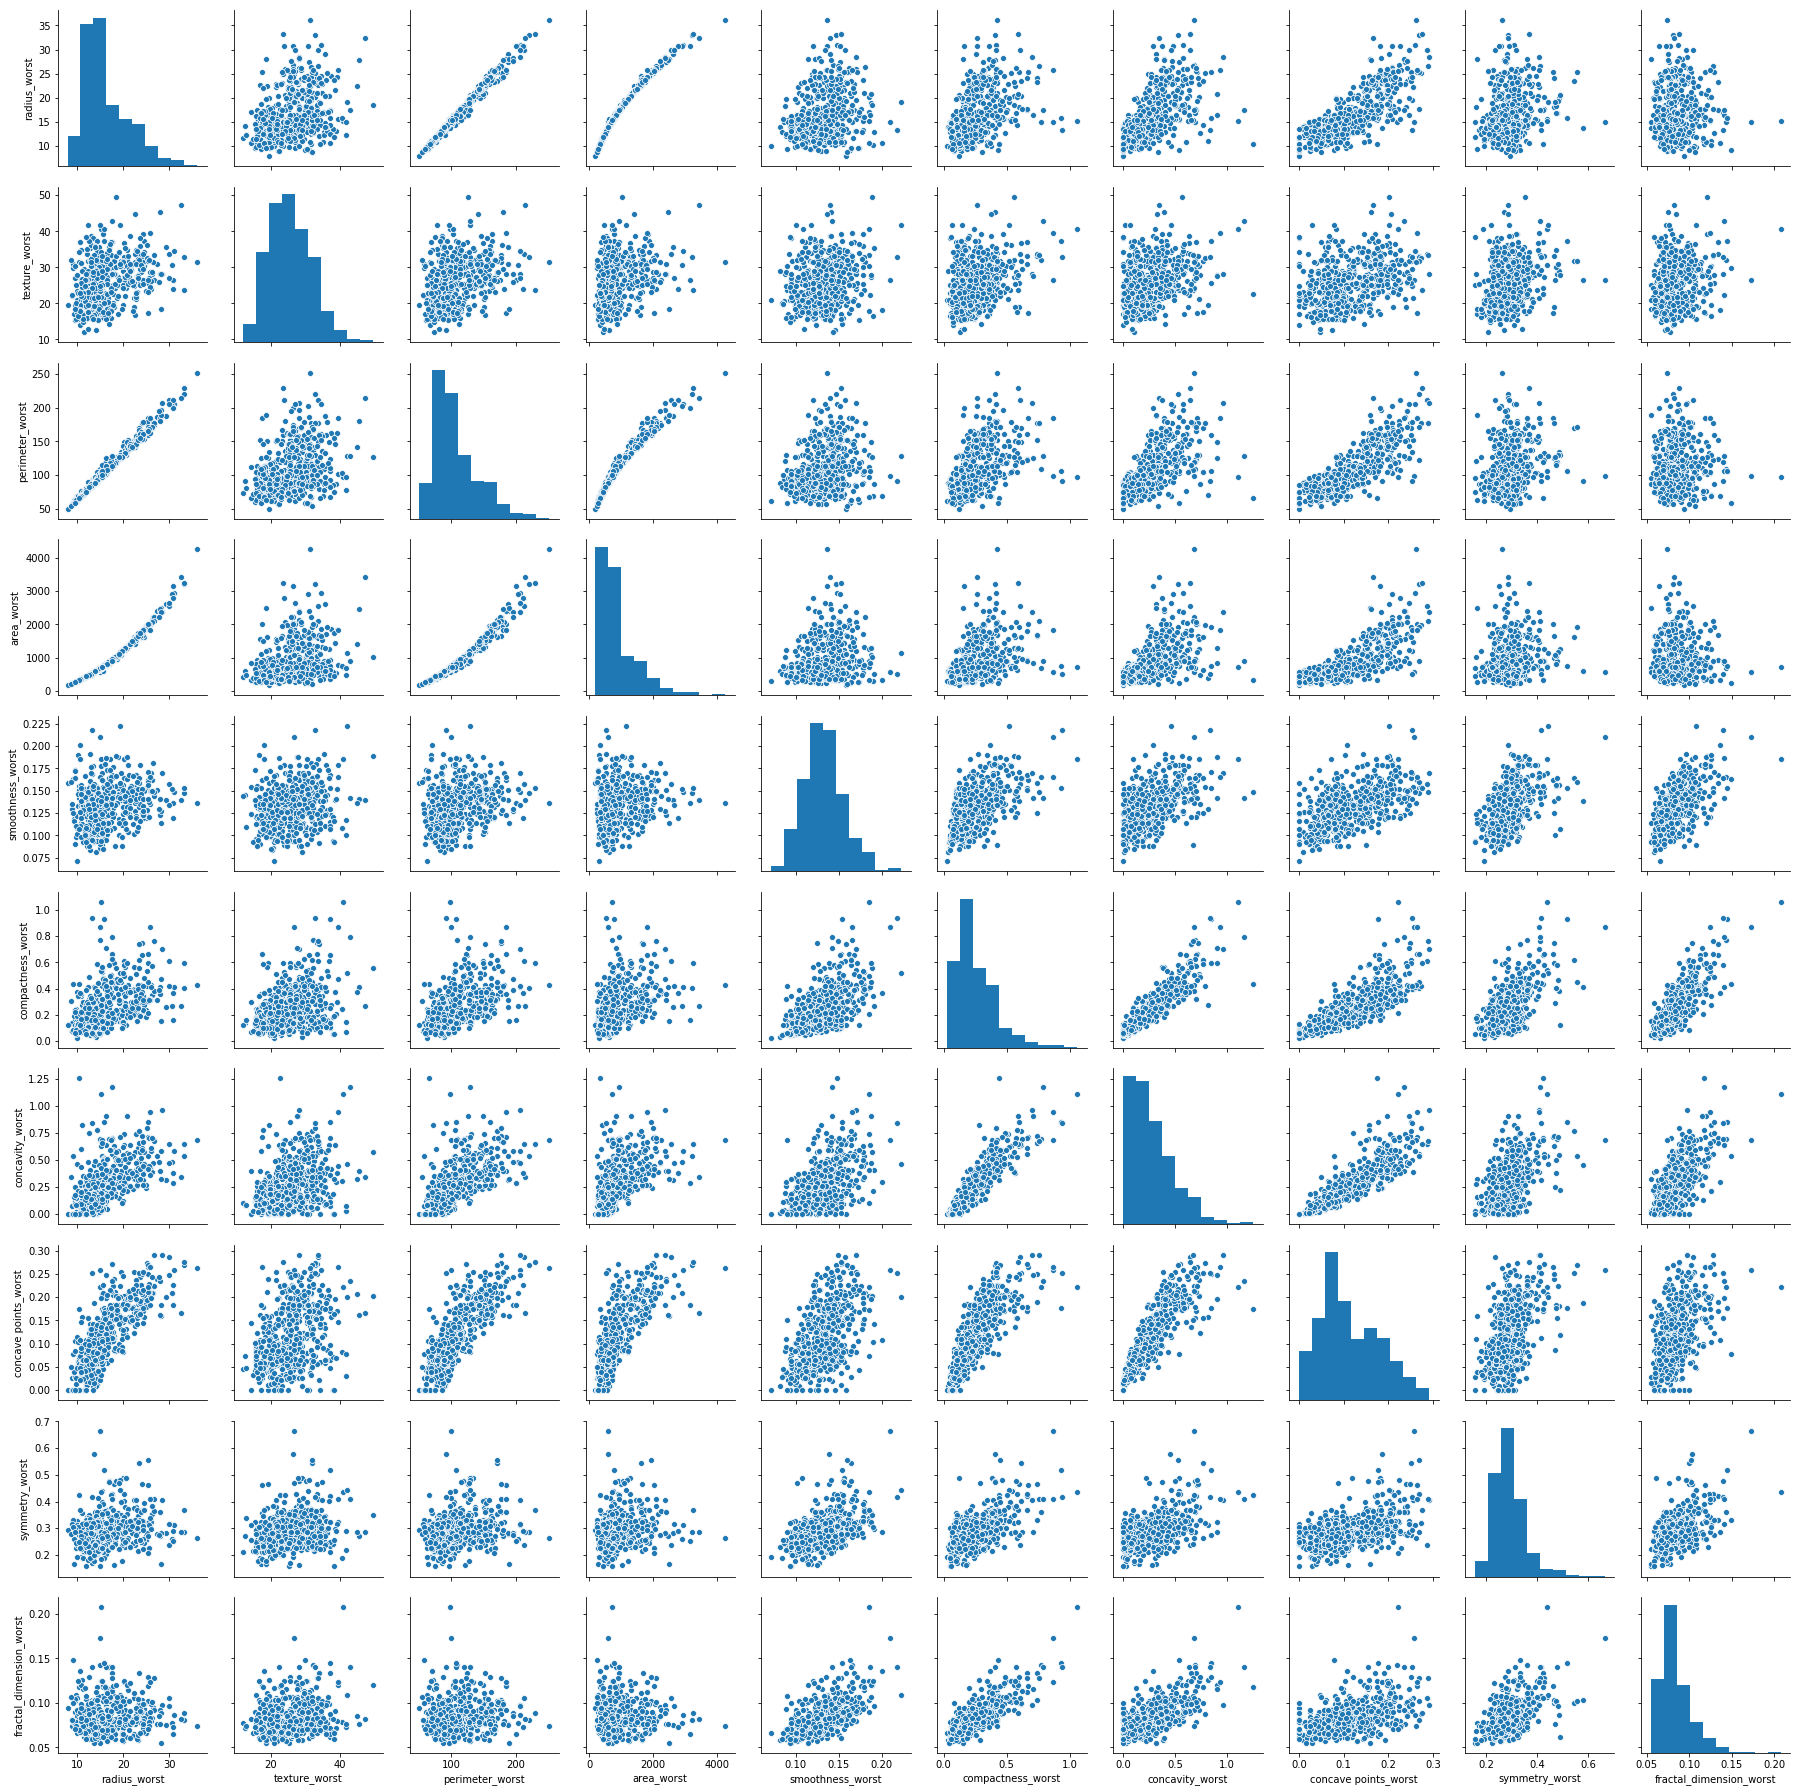

In [89]:
sns.pairplot(worst)

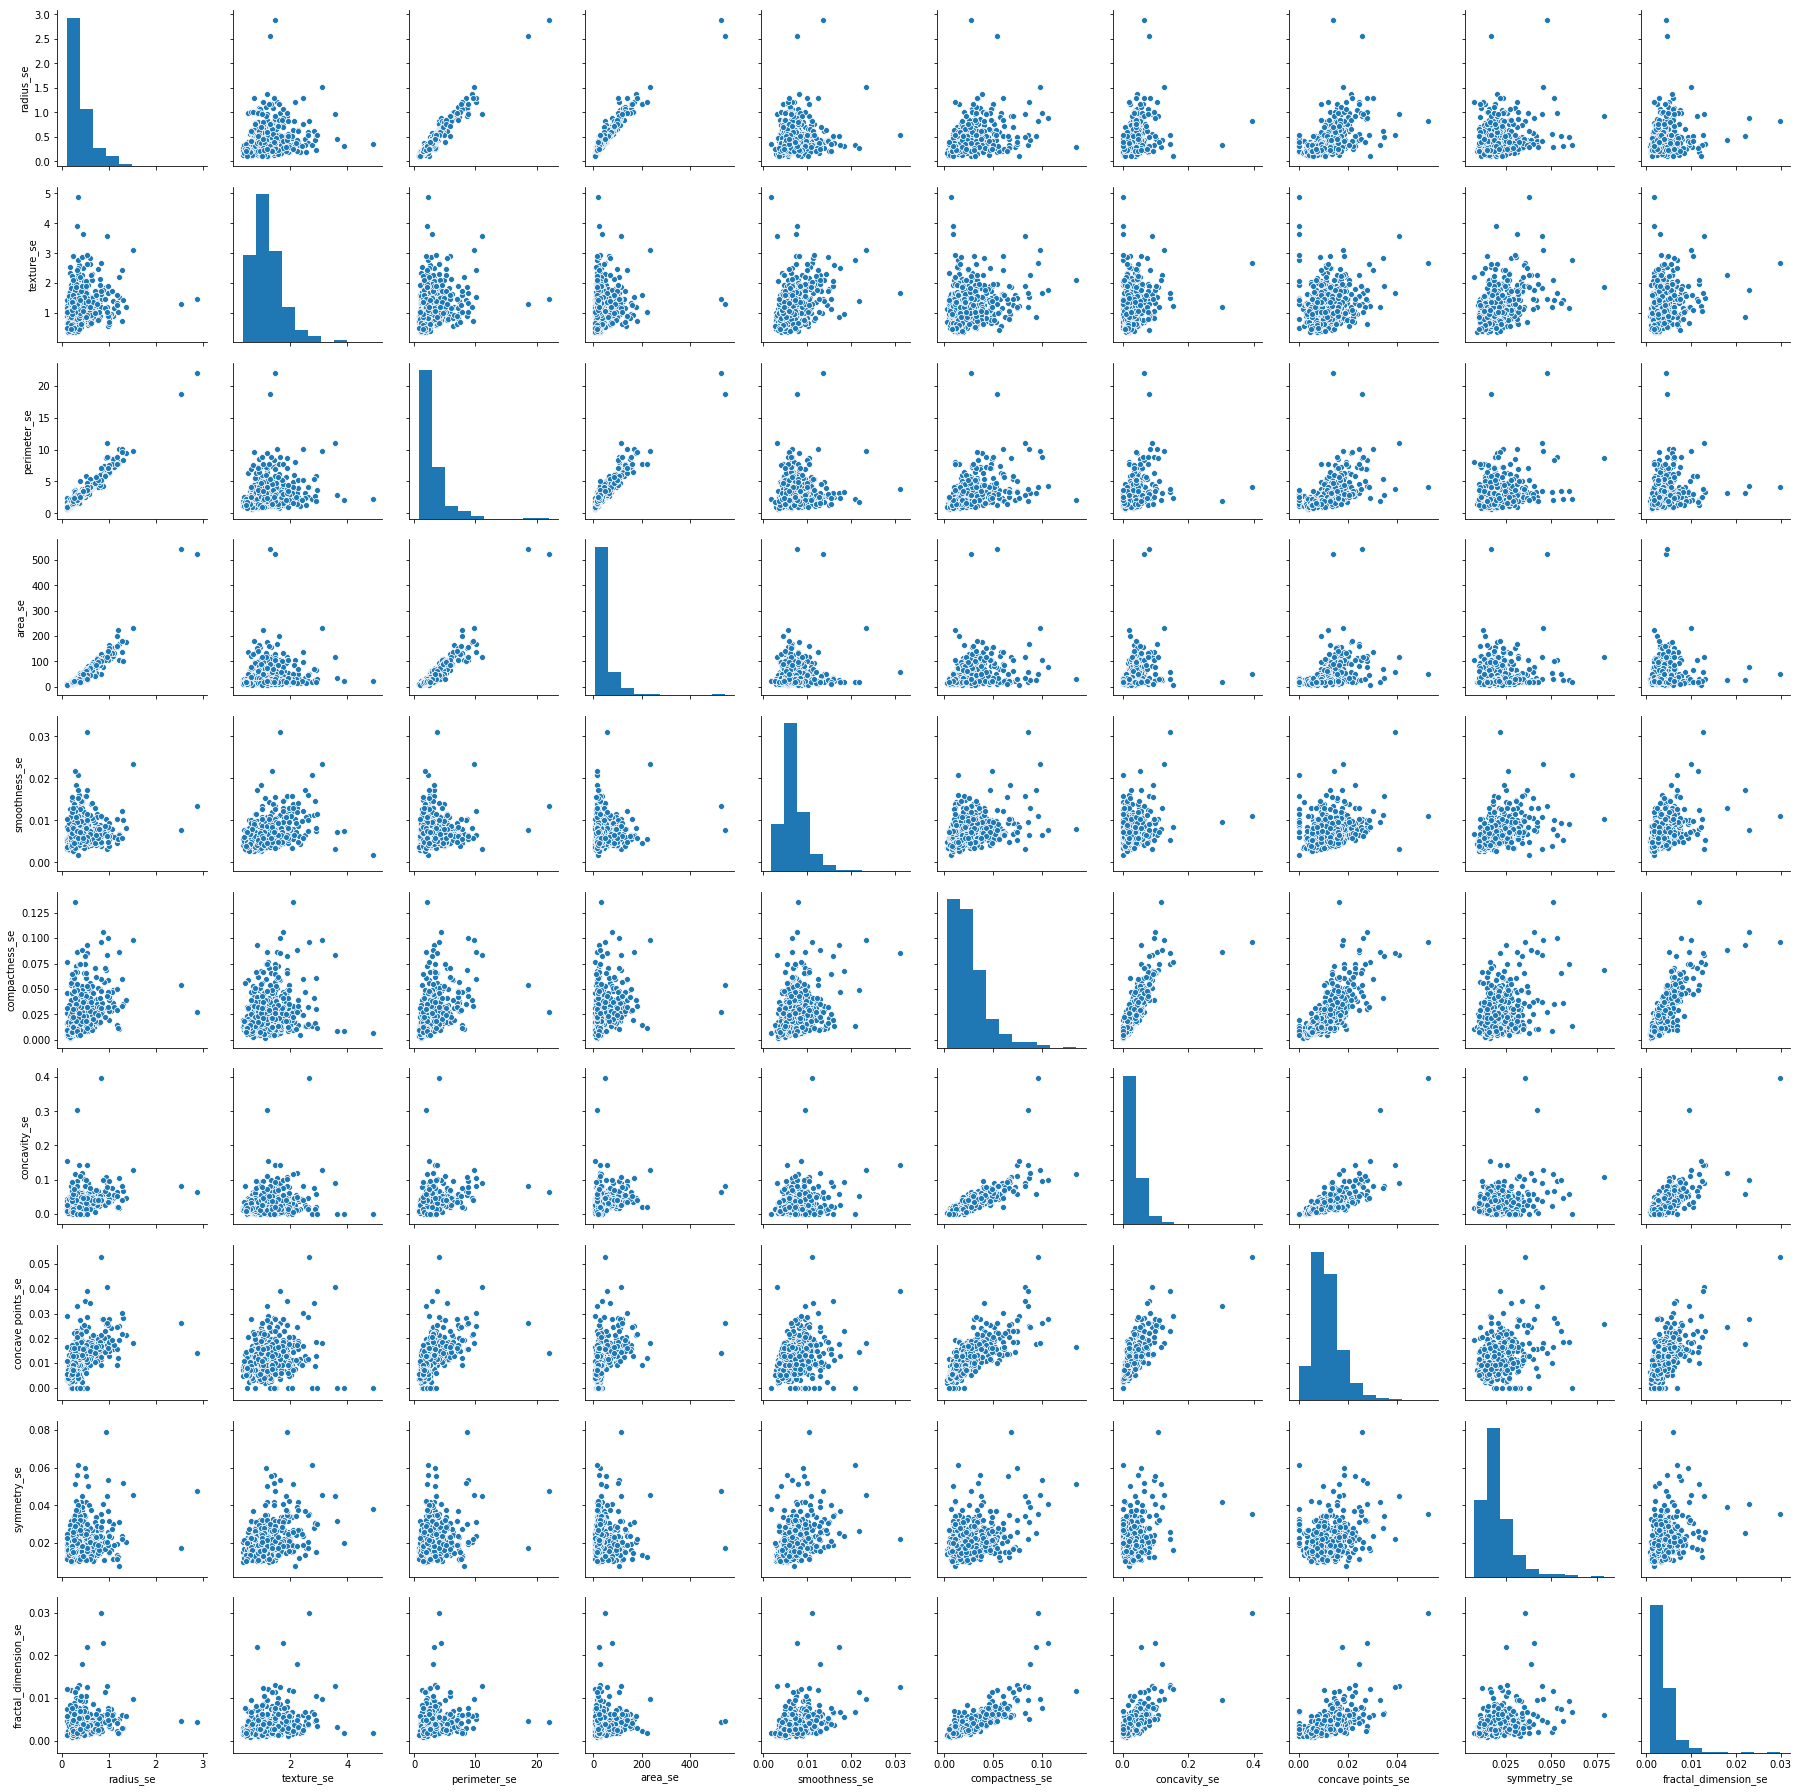

In [90]:
sns.pairplot(std)

## 6. Статистическая проверка взаимосвязей между переменными (pvalue)

## 7. Выбор стратегии Feature selection

## 8. Oversampling/Undersampling

## 9. Модель. Задача классификации

In [91]:
# Подготовка данных для решения задачи
X = data.drop(['diagnosis'], axis=1)
y = data['diagnosis']

X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.33, random_state=42)

### 9.1 Дерево решений

In [92]:
model_tree = DecisionTreeClassifier()

In [122]:
cross_val_score(model_tree, X_train, y_train, cv=10).mean()

0.9053470474523106

In [130]:
model_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### 9.2 Логистическая регрессия

In [124]:
model_logreg = LogisticRegression(penalty='l1', C=0.1)

In [128]:
cross_val_score(model_logreg, X_train, y_train, cv=10).mean()

0.9102618813145129

In [129]:
model_logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

## 10. Проверка качества классификации с помощью метрик

### 10.1 Accuracy

### 10.2 F1-Score

### 10.3 Precision

### 10.4 Recall

## 11. Качество вероятности класса с помощью метрики Brier Score